# KTR Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite, KTR

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

In [3]:
orbit.__version__

'1.0.16dev'

## Data

In [4]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [6]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTR

### KTR - Full

In [7]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [8]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -23156.2
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       427.989      0.465321       301.121           1           1       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       487.598     0.0303846       72.2146           1           1       46   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       488.324    0.00187406       41.2436       1.464      0.3575       72   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       488.608    0.00383823       37.2494           1           1       96   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.735   0.000548186       32.0746       2.431      0.5255      119   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [9]:
ktr.get_regression_coefs().head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.09624,0.07635,0.18297
1,2010-01-10,0.09602,0.07637,0.18286
2,2010-01-17,0.09581,0.07640,0.18275
3,2010-01-24,0.09559,0.07642,0.18264
4,2010-01-31,0.09536,0.07645,0.18253


In [10]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0,0.10948,0.07560,0.18904
1,2011-07-03,78,0.06522,0.07637,0.16996
2,2012-12-30,156,0.08176,0.10166,0.15963
3,2014-06-29,234,0.07357,0.10640,0.11727
4,2015-12-27,312,0.05870,0.09868,0.14646
5,2017-06-25,390,0.06254,0.07995,0.19699


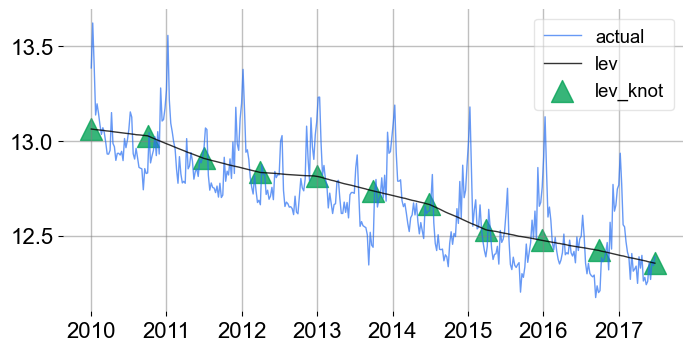

In [11]:
ktr.plot_lev_knots(figsize=(8, 4));

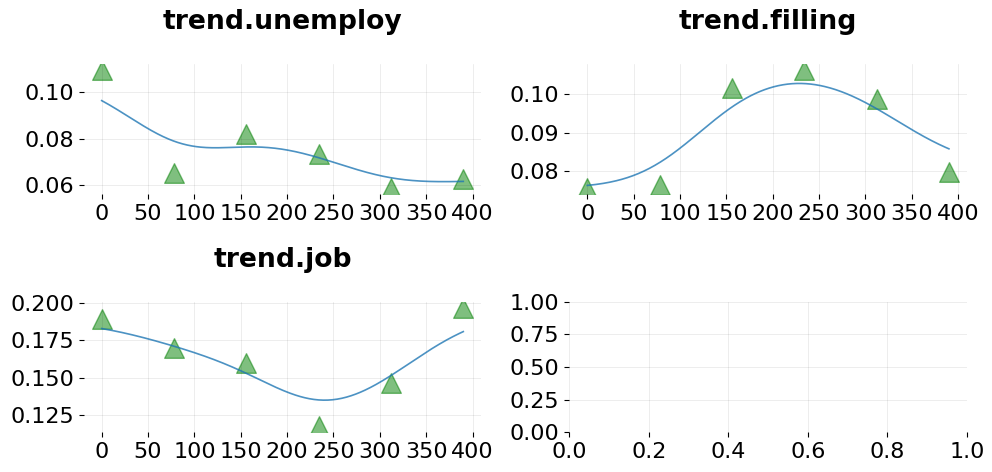

In [12]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=False);

In [13]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_input_5,seasonality_input,seasonality_input_95,regression_5,regression,regression_95
0,2017-07-02,11.85970,12.33659,12.81757,12.24627,12.35278,12.44570,-0.01455,-0.01455,-0.01455,-0.02982,0.00937,0.04881
1,2017-07-09,11.92050,12.36058,12.80572,12.24473,12.35251,12.44631,-0.02259,-0.02259,-0.02259,-0.01225,0.02346,0.05975
2,2017-07-16,11.88920,12.32219,12.79397,12.24513,12.35264,12.44578,-0.03450,-0.03450,-0.03450,-0.01152,0.01669,0.04682
3,2017-07-23,11.83738,12.31585,12.76160,12.24345,12.35234,12.44588,-0.05014,-0.05014,-0.05014,-0.00673,0.01888,0.04553
4,2017-07-30,11.83730,12.30239,12.76089,12.24224,12.35253,12.44631,-0.06903,-0.06903,-0.06903,-0.00764,0.02575,0.06001


In [14]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.76%'

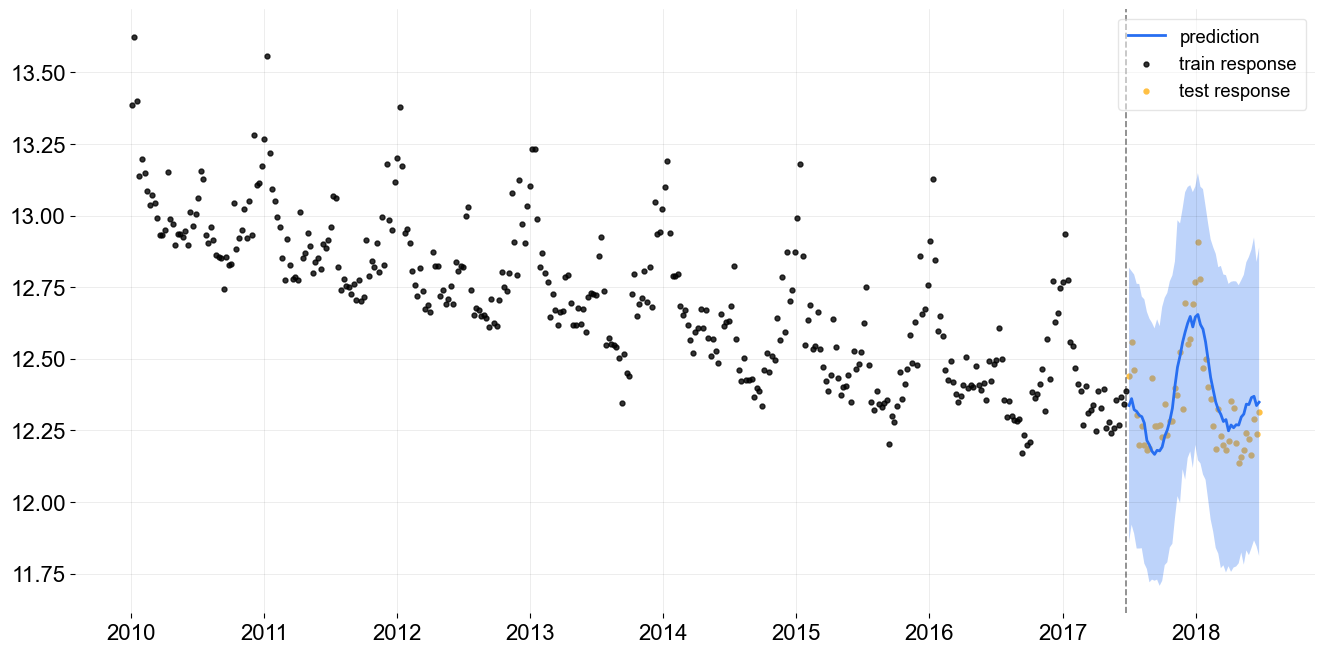

In [15]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

### KTR - Median

INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -32721.9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       431.993      0.042085       527.934      0.7521      0.7521       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       484.971      0.031511       71.1042           1           1       45   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       486.462    0.00173088       24.5858      0.2347           1       73   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        486.62    0.00218713       26.4439      0.6621      0.6621      100   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       486.662   0.000338614       17.4244      0.7973      0.7973      128   
    Iter      log prob        ||dx||      ||grad||       alpha  

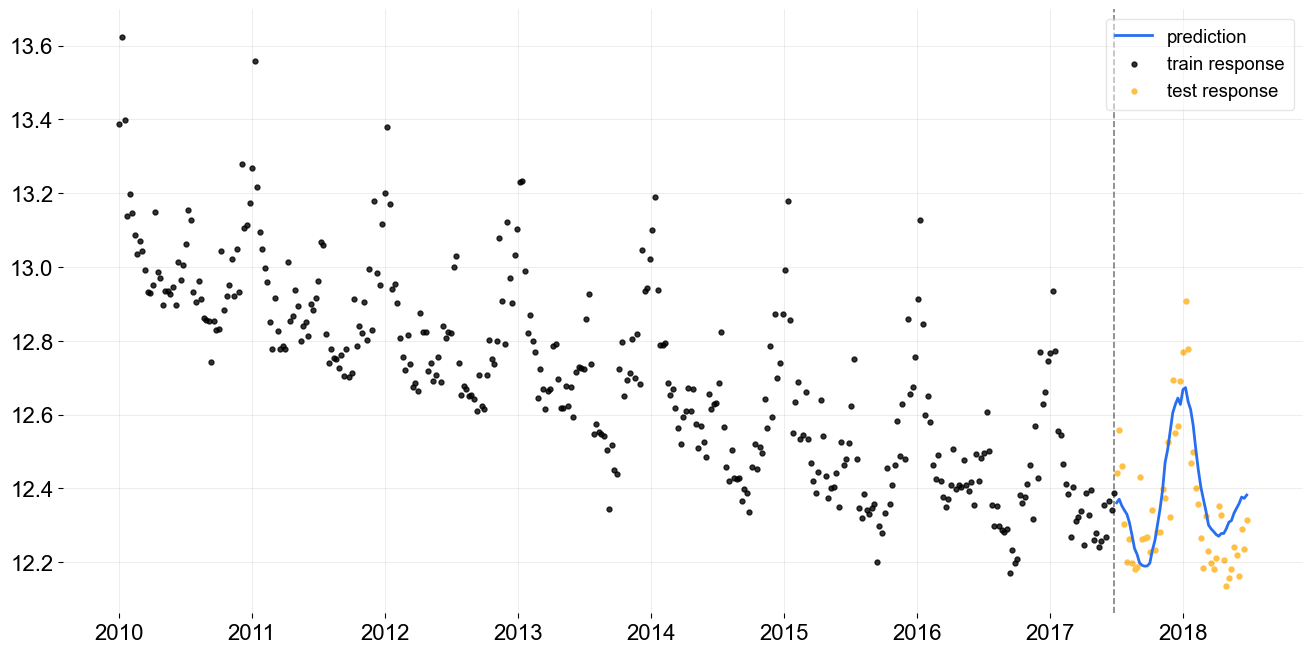

In [16]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=2,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

ktr.fit(df=train_df, point_method='median')
ktr.get_regression_coefs().head()

predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

## Electricity data (dual seasoanlity, no regressor)

In [17]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [18]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [19]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=20,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

In [20]:
ktr.fit(df=train_df, point_method='median')

INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -350615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -12521.3      0.274219       13159.6           1           1       31   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       3817.12     0.0998723       5244.48      0.1614           1       52   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       4986.04     0.0139157       771.127      0.6671      0.6671       74   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5046.84      0.052867       1079.43           1           1       97   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5137.35     0.0248511       317.611           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [21]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

,date,prediction,trend,seasonality_input,regression
360,2008-12-27,9.95271,9.99128,-0.03857,0.00000
361,2008-12-28,9.89752,9.99128,-0.09376,0.00000
362,2008-12-29,9.96214,9.99128,-0.02914,0.00000
363,2008-12-30,10.02384,9.99128,0.03257,0.00000
364,2008-12-31,10.00521,9.99128,0.01393,0.00000


In [22]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.52%'

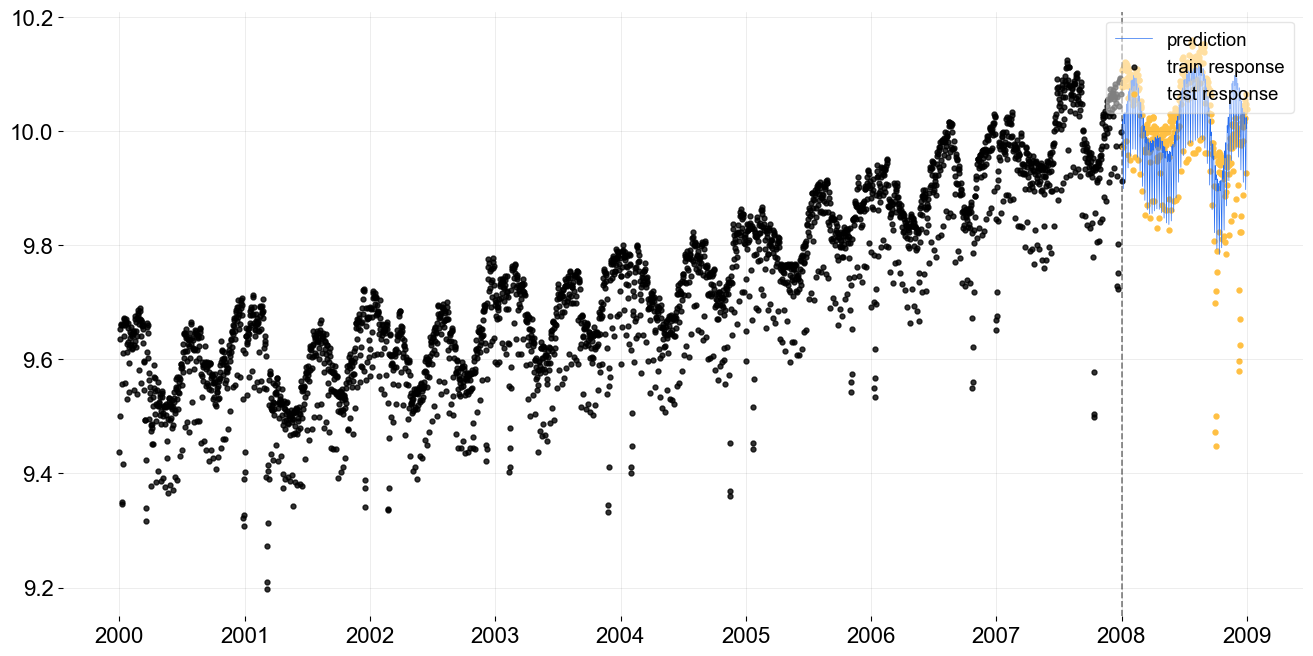

In [28]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                       lw=0.5)